## Accessing NLCD data on Azure

The [National Land Cover Database](https://www.mrlc.gov/national-land-cover-database-nlcd-2016) (NLCD) provides US-wide data on land cover and land cover change at a 30m resolution with a 16-class legend.  This Azure dataset reflects the CONUS and Alaska portions of NLCD 2016, which includes land cover for years 2001, 2003, 2006, 2008, 2011, 2013, and 2016.  

This notebook provides an example of accessing NLCD (National Land Cover Database) data from blob storage on Azure, including (1) looking at the directory where data is stored, (2) load the cloud optimized geotiff for a particular year, and (3) doing some simple processing and plotting of the data.

This dataset is stored in the West Europe Azure region, so this notebook will run most efficiently on Azure compute located in the same region.  If you are using this data for environmental science applications, consider applying for an [AI for Earth grant](http://aka.ms/ai4egrants) to support your compute requirements.

This dataset is documented at [aka.ms/ai4edata-nlcd](http://aka.ms/ai4edata-nlcd).

### Environment setup

In [1]:
import fsspec
import matplotlib.pyplot as plt 
import numpy as np
import xarray as xr

account_name = 'cpdataeuwest'
container = 'cpdata'
year = 2001
area = 'conus' # 'conus' or 'ak' (for Alaska)

### View all the available nationwide land cover products

In [2]:
fs = fsspec.get_filesystem_class('az')(account_name=account_name)
fs.ls(path=f'{container}/raw/nlcd/{area}/30m/')

['cpdata/raw/nlcd/conus/30m/2001.tif',
 'cpdata/raw/nlcd/conus/30m/2004.tif',
 'cpdata/raw/nlcd/conus/30m/2006.tif',
 'cpdata/raw/nlcd/conus/30m/2008.tif',
 'cpdata/raw/nlcd/conus/30m/2011.tif',
 'cpdata/raw/nlcd/conus/30m/2013.tif',
 'cpdata/raw/nlcd/conus/30m/2016.tif',
 'cpdata/raw/nlcd/conus/30m/change.tif']

### Load data for a single year

In [3]:
url = f'https://{account_name}.blob.core.windows.net/' + \
                      f'{container}/raw/nlcd/{area}/30m/{year}.tif'
da = xr.open_rasterio(url,chunks=dict(x=2560, y=2560))
print(url)

# Transform our data array to dataset by selecting the only data variable ('band'), and
# rename it to something useful ('landcover')
ds = da.to_dataset(dim='band').rename({1: 'landcover'})
ds

https://cpdataeuwest.blob.core.windows.net/cpdata/raw/nlcd/conus/30m/2001.tif


<xarray.Dataset>
Dimensions:    (x: 161190, y: 104424)
Coordinates:
  * y          (y) float64 3.31e+06 3.31e+06 3.31e+06 ... 1.773e+05 1.773e+05
  * x          (x) float64 -2.493e+06 -2.493e+06 ... 2.343e+06 2.343e+06
Data variables:
    landcover  (y, x) uint8 dask.array<chunksize=(2560, 2560), meta=np.ndarray>
Attributes:
    transform:           (30.0, 0.0, -2493045.0, 0.0, -30.0, 3310005.0)
    crs:                 +proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45...
    res:                 (30.0, 30.0)
    is_tiled:            1
    nodatavals:          (nan,)
    scales:              (1.0,)
    offsets:             (0.0,)
    descriptions:        ('Layer_1',)
    AREA_OR_POINT:       Area
    OVR_RESAMPLING_ALG:  NEAREST

### Load and downsample forest cover data

In [4]:
# Let's look at forest lands in the U.S. 
#
# Land cover data are stored as categorical variables, and the legend for the code
# can be found in: 
#
# https://www.mrlc.gov/data/legends/national-land-cover-database-2016-nlcd2016-legend
#
# Forest lands correspond to codes 41, 42, and 43.

deciduous = ds.landcover.isin([41]).astype(int)
evergreen = ds.landcover.isin([42]).astype(int)
mixed     = ds.landcover.isin([43]).astype(int)

# Coarsen by 100x on each dimension to get to a reasonable plotting size 
factor = 100
deciduous = deciduous.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
evergreen = evergreen.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()
mixed = mixed.coarsen(dim={'x': factor, 'y': factor}, boundary='trim').mean().compute()

In [5]:
mixed

<xarray.DataArray 'landcover' (y: 1044, x: 1611)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
  * y        (y) float64 3.309e+06 3.306e+06 3.303e+06 ... 1.825e+05 1.795e+05
  * x        (x) float64 -2.492e+06 -2.489e+06 ... 2.335e+06 2.338e+06

### Plot forest distributions over CONUS

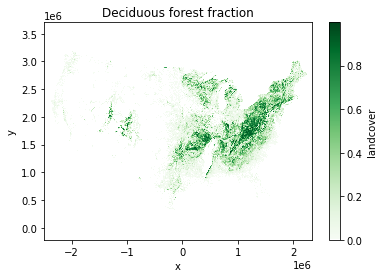

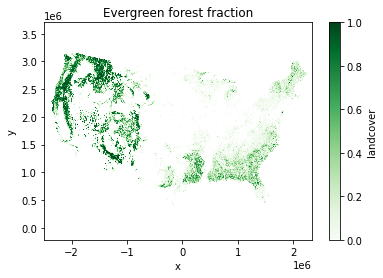

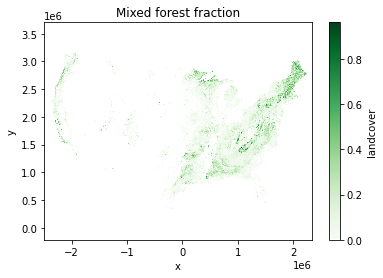

In [6]:
# Create a custom colormap that makes zeros white
import matplotlib
from matplotlib import cm
cmap = cm.get_cmap('Greens')
cmaplist = [cmap(i) for i in range(cmap.N)]
cmaplist[0] = (1.0,1.0,1.0,1.0)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('mcm',cmaplist, cmap.N)

deciduous.plot(cmap=cmap)
plt.title('Deciduous forest fraction')
plt.axis('equal')
plt.show()

evergreen.plot(cmap=cmap)
plt.title('Evergreen forest fraction')
plt.axis('equal')
plt.show()

mixed.plot(cmap=cmap)
plt.title('Mixed forest fraction')
plt.axis('equal')
plt.show()

### Plot an overview of nationwide land cover

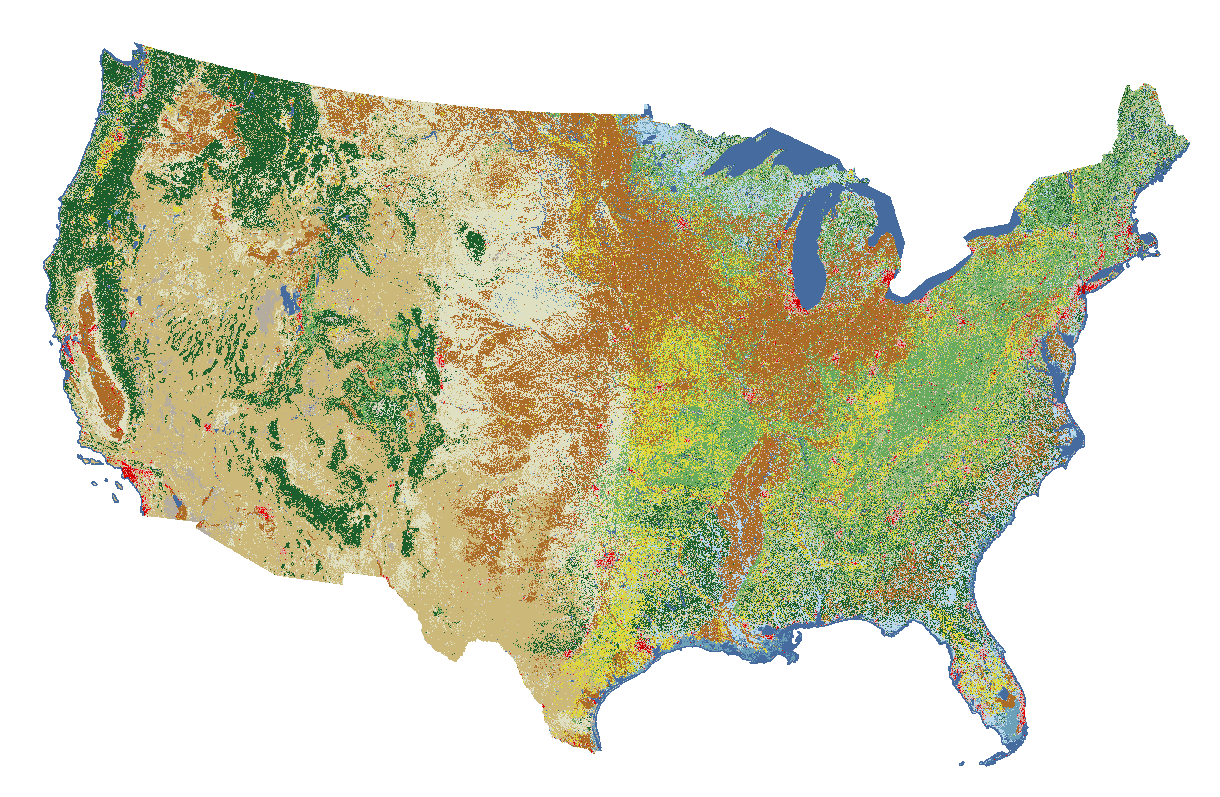

In [7]:
# With help from:
#
# https://automating-gis-processes.github.io/CSC/notebooks/L5/read-cogs.html

import rasterio
import json
fp = url
with rasterio.open(fp) as src:
    
    # List of overviews from biggest to smallest
    oviews = src.overviews(1)

    # Retrieve one of the thumbnails without reading the COG
    oview = oviews[-3]
    thumbnail = src.read(1, out_shape=(1, int(src.height // oview), int(src.width // oview)))
    
    # Convert 0 values to NaNs
    thumbnail = thumbnail.astype('f4')
    thumbnail[thumbnail==0] = np.nan

fig = plt.figure(frameon=False, figsize=(12,8), dpi=100); ax = plt.Axes(fig,[0., 0., 1., 1.]); 
ax.set_axis_off(); fig.add_axes(ax)

# Load the NLCD colormap from file
with open("colormaps.json","r") as f:
    presets = json.load(f)
colors = []
for i in range(256):
    i = str(i) # json only allows keys to be strings
    if i in presets["nlcd"]:
        r,g,b,a = presets["nlcd"][i]
        colors.append((r/255.0, g/255.0, b/255.0, a/255.0))
    else:
        colors.append((0,0,0,0))
cmap = matplotlib.colors.ListedColormap(colors)

plt.imshow(thumbnail,cmap=cmap,vmin=0,vmax=256,interpolation="none");